# mlflow: Bias Variance Data Tradeoff

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [134]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

## Generate data

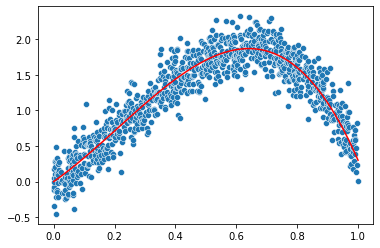

In [135]:
X = np.sort(np.random.uniform(0, 1, 1000))
noise = np.random.normal(0,0.2,1000)
# true function f(x) = 10x - 5x^2 + 0.5x^3
true_function = 3*X + 4*X**2 -6*(X**3)-0.7*(X**4)
y=true_function + noise
sns.scatterplot(x=X, y=y)
sns.lineplot(x=X, y=true_function, color='r')
plt.show()

## Fit initial model

#### Polynomial Features

In [136]:
poly_transf = PolynomialFeatures(degree=4, include_bias = False)
test_poly = poly_transf.fit_transform(X.reshape(-1, 1))
test_poly.shape

(1000, 4)

In [137]:
pd.DataFrame(test_poly).head()

,0,1,2,3
0,0.000002,5.322036e-12,1.227769e-17,2.832407e-23
1,0.000635,4.030490e-07,2.558802e-10,1.624485e-13
2,0.000753,5.662915e-07,4.261477e-10,3.206861e-13
3,0.001019,1.038396e-06,1.058144e-09,1.078267e-12
4,0.001433,2.053597e-06,2.942881e-09,4.217259e-12


In [138]:
features_df = pd.DataFrame(test_poly)
features_df.head()

,0,1,2,3
0,0.000002,5.322036e-12,1.227769e-17,2.832407e-23
1,0.000635,4.030490e-07,2.558802e-10,1.624485e-13
2,0.000753,5.662915e-07,4.261477e-10,3.206861e-13
3,0.001019,1.038396e-06,1.058144e-09,1.078267e-12
4,0.001433,2.053597e-06,2.942881e-09,4.217259e-12


In [139]:
features_df.describe()

,0,1,2,3
count,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.504278,3.378614e-01,2.531297e-01,2.018006e-01
std,0.289221,2.962060e-01,2.808337e-01,2.636022e-01
min,0.000002,5.322036e-12,1.227769e-17,2.832407e-23
25%,0.254861,6.495416e-02,1.655429e-02,4.219045e-03
50%,0.512920,2.630872e-01,1.349428e-01,6.921491e-02
75%,0.756275,5.719520e-01,4.325531e-01,3.271291e-01
max,0.999953,9.999053e-01,9.998580e-01,9.998106e-01


In [140]:
targets = y

#split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(features_df, targets, test_size=0.33, random_state=1)

In [141]:
# normalize
## training features
print("\ntrain features pre normalization")
print(X_train.mean(axis=0))
print(X_train.std(axis=0))
scaler = scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

print("\ntrain features post normalization")
print(X_train.mean(axis=0))
print(X_train.std(axis=0))

## test features
print("\ntest features pre normalization")
print(X_test.mean(axis=0))
print(X_test.std(axis=0))
X_test = scaler.transform(X_test)

print("\ntest features post normalization")
print(X_test.mean(axis=0))
print(X_test.std(axis=0))


train features pre normalization
0    0.502459
1    0.335116
2    0.250457
3    0.199408
dtype: float64
0    0.287705
1    0.295357
2    0.279856
3    0.262232
dtype: float64

train features post normalization
[-2.36295229e-16 -9.41535407e-16 -6.31170075e-16 -3.22461792e-16]
[1. 1. 1. 1.]

test features pre normalization
0    0.507971
1    0.343435
2    0.258557
3    0.206658
dtype: float64
0    0.292677
1    0.298295
2    0.283158
3    0.266697
dtype: float64

test features post normalization
[0.01917283 0.02818668 0.02896502 0.02766752]
[1.01649655 1.0091714  1.01102071 1.01624474]


In [146]:
#first fit a simple linear regression OR NOT
simple = LinearRegression(fit_intercept=True)
simple.fit(X_train, y_train.reshape(-1,1))

# estimate bias and variance
mse, bias, var = bias_variance_decomp(simple, X_train,
                                      y_train, X_test,
                                      y_test, loss='mse', num_rounds=2000, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.041
Bias: 0.040
Variance: 0.000


In [147]:
r_2 = simple.score(X_test, y_test)
print(f'original model R^2 = {r_2}')

original model R^2 = 0.8870712863455212


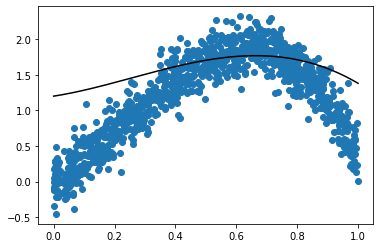

In [148]:
plt.scatter(features_df[0], y)
plt.plot(features_df[0], simple.predict(features_df), color='k')

In [149]:
simple.intercept_

1.1999894552101313

In [150]:
simple.coef_

array([ 0.66366593,  1.98597962, -2.72209462,  0.25279261])

# Pipeline

In [151]:
X_df = pd.DataFrame(X)
X_df.columns = ['col_1']
X_df['target'] = y
X_df.head()

,col_1,target
0,0.000002,-0.103592
1,0.000635,-0.115651
2,0.000753,-0.105169
3,0.001019,-0.113251
4,0.001433,-0.347372


In [152]:
train, test = train_test_split(X_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(f"shape train: {train.shape}")
print(f"shape validation: {val.shape}")
print(f"shape test: {test.shape}")

shape train: (640, 2)
shape validation: (160, 2)
shape test: (200, 2)


In [153]:
numeric_features = ['col_1']
numeric_transformer = Pipeline(steps=[
     ('polynomials', PolynomialFeatures(degree=4, include_bias = False)),
     ('scaler', StandardScaler())])

In [156]:
preprocessor = ColumnTransformer(
     transformers=[
          ('num', numeric_transformer, numeric_features)])

In [158]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
     ('regression', LinearRegression(fit_intercept=True))], verbose=True)

In [159]:
#fit the pipeline
clf.fit(train, train['target'].values)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing regression, total=   0.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomials',
                                                                   PolynomialFeatures(degree=4,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['col_1'])])),
                ('regression', LinearRegression())],
         verbose=True)

In [160]:
y_pred = clf.predict(val)

In [162]:
X_df

,col_1,target
0,0.000002,-0.103592
1,0.000635,-0.115651
2,0.000753,-0.105169
3,0.001019,-0.113251
4,0.001433,-0.347372
...,...,...
995,0.993516,0.139635
996,0.994336,0.466008
997,0.997613,0.823099
998,0.997967,0.230414


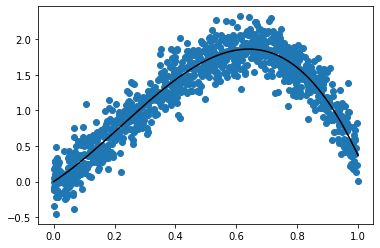

In [163]:
plt.scatter(X_df['col_1'], X_df['target'])
plt.plot(X_df['col_1'], clf.predict(X_df), color='k')

In [167]:
clf.named_steps['regression'].coef_

array([ 0.79743893,  1.46399866, -2.12741956,  0.08422539])

In [168]:
clf.named_steps['regression'].intercept_

1.2026582864271516

# mlflow

In [171]:
with mlflow.start_run():
    mlflow.log_metric("r2", r2_score( val['target'].values, y_pred))
    mlflow.log_metric("mse", mean_squared_error( val['target'].values, y_pred))

# Model Complexity stuff
will take forever

In [49]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(features_df, targets, test_size=0.33, random_state=1)

# normalize
## training features
print("\ntrain features pre normalization")
print(X_train.mean(axis=0))
print(X_train.std(axis=0))
scaler = scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

print("\ntrain features post normalization")
print(X_train.mean(axis=0))
print(X_train.std(axis=0))

## test features
print("\ntest features pre normalization")
print(X_test.mean(axis=0))
print(X_test.std(axis=0))
X_test = scaler.transform(X_test)

print("\ntest features post normalization")
print(X_test.mean(axis=0))
print(X_test.std(axis=0))


train features pre normalization
0    1.000000
1    0.520776
2    0.353325
3    0.266738
4    0.213768
5    0.178033
6    0.152319
7    0.132948
8    0.117847
dtype: float64
0    0.000000
1    0.286775
2    0.298433
3    0.285115
4    0.268809
5    0.253506
6    0.239905
7    0.227953
8    0.217438
dtype: float64

train features post normalization
[ 0.00000000e+00 -1.11842542e-15 -1.66050838e-15 -9.35570029e-16
 -1.01481841e-15 -4.06971306e-16 -4.54280063e-16 -1.24941517e-16
  4.51214522e-16]
[0. 1. 1. 1. 1. 1. 1. 1. 1.]

test features pre normalization
0    1.000000
1    0.501799
2    0.332303
3    0.246783
4    0.195236
5    0.160864
6    0.136402
7    0.118181
8    0.104138
dtype: float64
0    0.000000
1    0.284157
2    0.291665
3    0.275191
4    0.257336
5    0.241538
6    0.228087
7    0.216673
8    0.206918
dtype: float64

test features post normalization
[ 0.         -0.0662213  -0.070493   -0.07004433 -0.06899178 -0.06777793
 -0.06639548 -0.06483048 -0.06309443]
[0.         

In [50]:
alphas = np.linspace(0,5,100)
ddict = {'alpha': [], 'MSE': [], 'Bias': [], 'Variance': [], 'r^2': [],
         'intercept':[],
        }
coefs_dict = {'coef_'+str(i+1):[] for i in range(X_train.shape[1])}

ddict.update(coefs_dict)
for alpha in alphas:
    rg = linear_model.Ridge(alpha=alpha)   
    rg.fit(X_train, y_train.reshape(-1,1))

    # estimate bias and variance
    mse, bias, var = bias_variance_decomp(rg, X_train,
                                          y_train, X_test,
                                          y_test, loss='mse', num_rounds=2000, random_seed=1)
    
    r_2 = rg.score(X_test, y_test)
    new_dict = {'MSE': mse, 'Bias': bias, 'Variance': var, 'r^2': r_2}
    ddict['alpha'].append(alpha)
    ddict['MSE'].append(new_dict['MSE'])
    ddict['Bias'].append(new_dict['Bias'])
    ddict['Variance'].append(new_dict['Variance'])
    ddict['r^2'].append(new_dict['r^2'])
    ddict['intercept'].append(rg.intercept_)
    
    for i in range(len(rg.coef_)):
        coef_key = 'coef_'+str(i+1)
        ddict[coef_key] = rg.coef_[i]
    

In [51]:
results = pd.DataFrame(ddict)
results.head(n=10)

,alpha,MSE,Bias,Variance,r^2,intercept,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7,coef_8,coef_9
0,0.000000,1.022918,1.009383,0.013534,0.251355,1.203547,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158
1,0.050505,1.013752,1.005721,0.008031,0.251795,1.203340,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158
2,0.101010,1.011099,1.003335,0.007764,0.252607,1.203313,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158
3,0.151515,1.009004,1.001403,0.007601,0.253351,1.203272,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158
4,0.202020,1.007227,0.999753,0.007474,0.254010,1.203229,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158
5,0.252525,1.005682,0.998314,0.007368,0.254592,1.203187,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158
6,0.303030,1.004323,0.997045,0.007277,0.255107,1.203147,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158
7,0.353535,1.003115,0.995917,0.007198,0.255563,1.203108,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158
8,0.404040,1.002034,0.994907,0.007127,0.255969,1.203071,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158
9,0.454545,1.001063,0.993998,0.007065,0.256333,1.203036,0.0,1.151163,-0.002551,-0.22819,-0.199571,-0.135507,-0.100307,-0.109144,-0.161158


Text(0.5, 1.0, 'R^2')

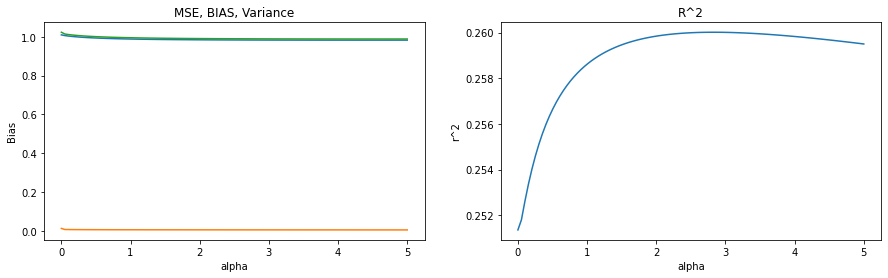

In [52]:
fig, ax = plt.subplots(ncols=2, figsize=(15,4))

# results.head(5)
sns.lineplot(x='alpha', y='Bias', data=results, ax=ax[0])
sns.lineplot(x='alpha', y='Variance', data=results, ax=ax[0])
ax_plot1 = sns.lineplot(x='alpha', y='MSE', data=results, ax=ax[0])
ax_plot1.set_title('MSE, BIAS, Variance')

ax_plot_2 = sns.lineplot(x='alpha', y='r^2', data=results, ax=ax[1])
ax_plot_2.set_title("R^2")

/Users/christineibaraki/Documents/workspace/bias_variance_explo/env/lib/python3.8/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/Users/christineibaraki/Documents/workspace/bias_variance_explo/env/lib/python3.8/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/Users/christineibaraki/Documents/workspace/bias_variance_explo/env/lib/python3.8/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


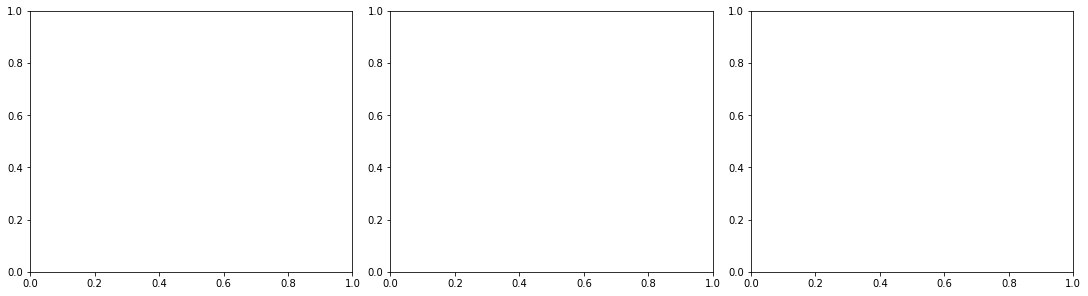

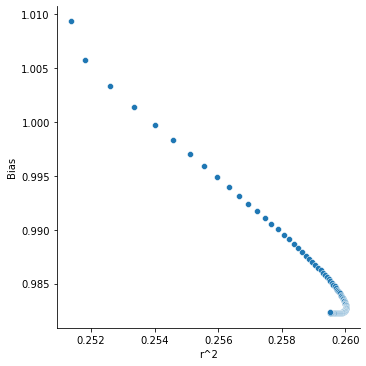

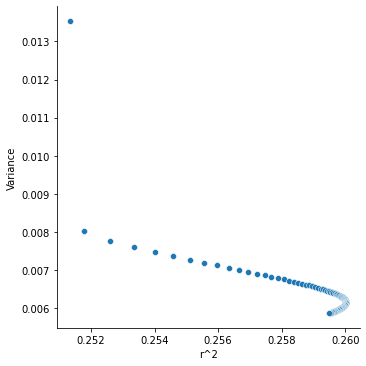

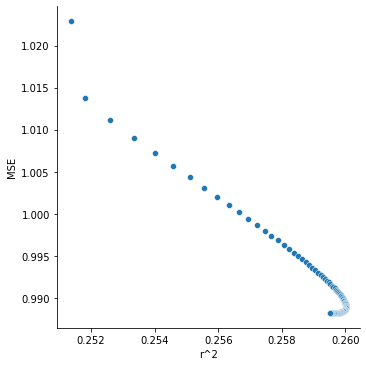

In [54]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), constrained_layout=True)
sns.relplot(x='r^2', y='Bias', data=results, ax=ax[0])
sns.relplot(x='r^2', y='Variance', data=results, ax=ax[1])
sns.relplot(x='r^2', y='MSE', data=results, ax=ax[2])
# plt.close(2)
# plt.close(3)
# plt.close(4)
plt.show()

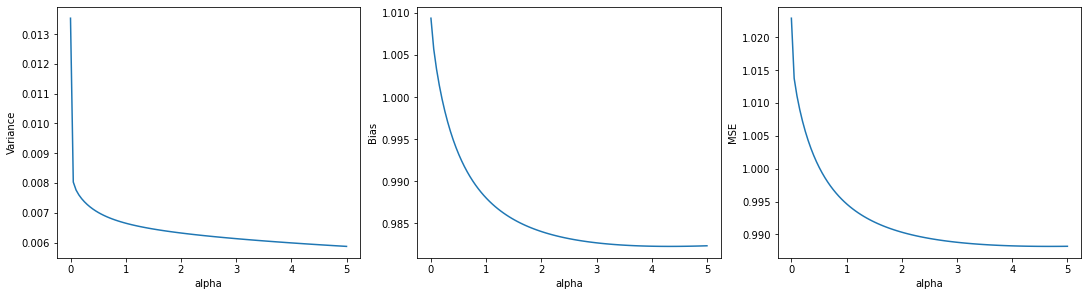

In [55]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), constrained_layout=True)
sns.lineplot(x='alpha', y='Variance', data=results, ax=ax[0])
sns.lineplot(x='alpha', y='Bias', data=results, ax=ax[1])
sns.lineplot(x='alpha', y='MSE', data=results, ax=ax[2])
plt.show()

In [56]:
results['alpha'][results['MSE']==results['MSE'].min()]

93    4.69697
Name: alpha, dtype: float64

Text(0.5, 1.0, 'Coef estimate by alpha')

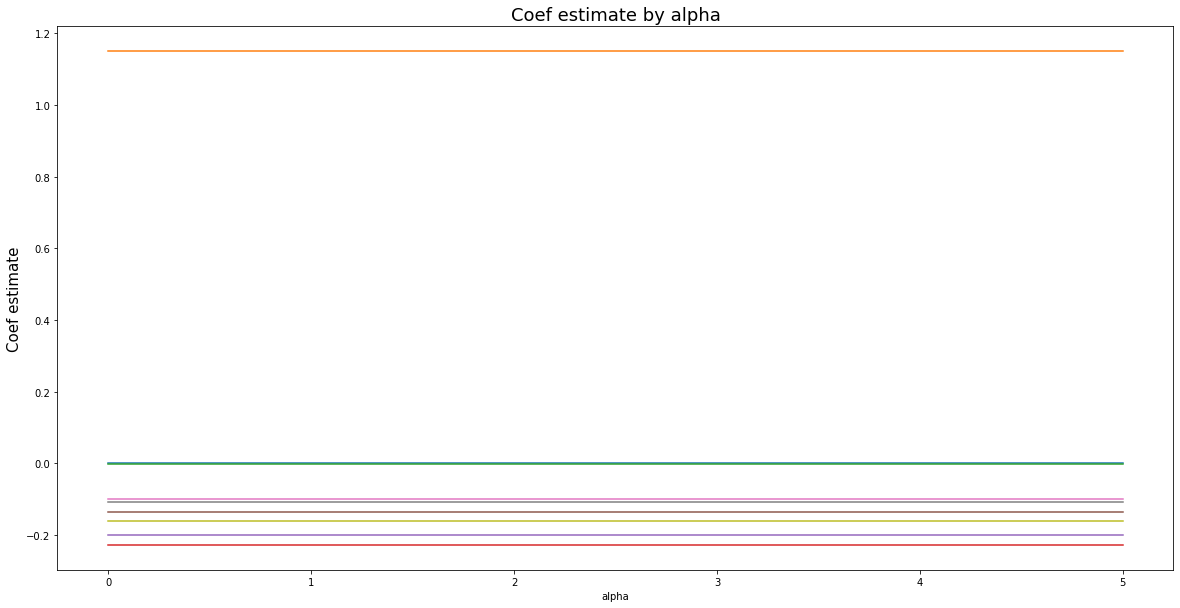

In [57]:
plt.figure(figsize=(20,10))
for i in range(X_train.shape[1]):
    var_name = 'coef_'+str(i+1)
    sns.lineplot(x='alpha', y=var_name, data=results)
plt.ylabel("Coef estimate", size=15)
plt.title("Coef estimate by alpha", size=18)

Text(0.5, 1.0, 'intercept estimate by alpha')

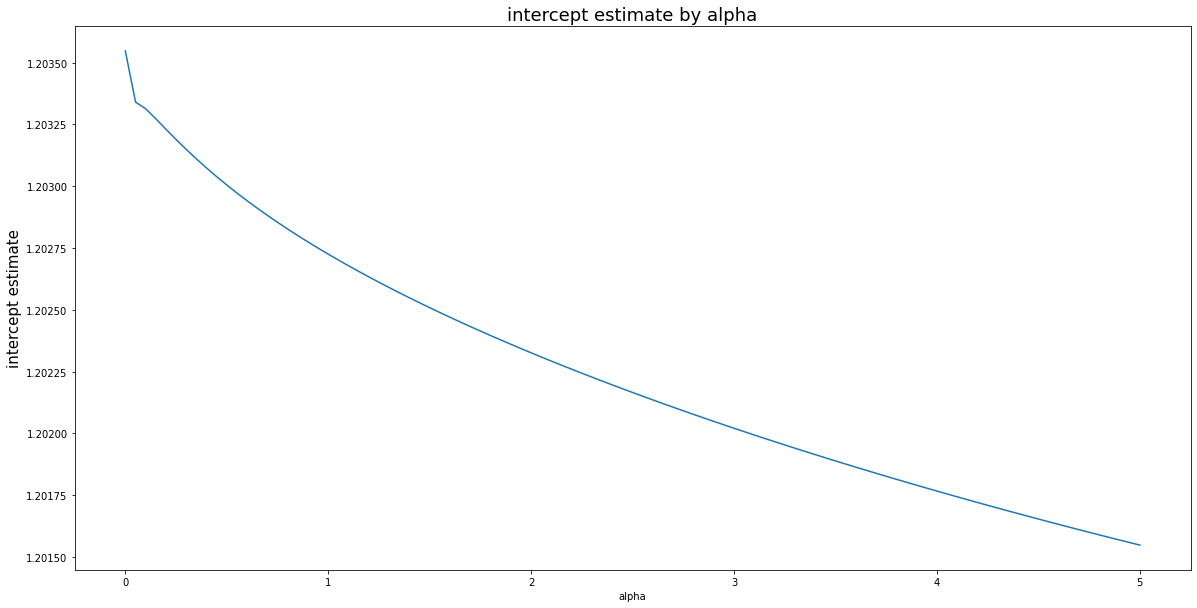

In [58]:
plt.figure(figsize=(20,10))
sns.lineplot(x='alpha', y='intercept', data=results)
plt.ylabel("intercept estimate", size=15)
plt.title("intercept estimate by alpha", size=18)